In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from dataloading import SpectrogramDataset
from torch.utils.data._utils.collate import default_collate

from torchsummary import summary
import matplotlib.pyplot as plt
plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from dataloading import repeat_channels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])
transform_eNetV2S = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

In [18]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
WINDOW_SIZE = 200  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.0  # overlap between consecutive windows

dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform)

# split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=default_collate, num_workers=0)

#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/94 [00:00<?, ?it/s]

Last odd spectrogram slice shape: (800, 200)
Total number of windows = 1225
Number of unique IDs = 1225


In [19]:
import timm

# EfficientNetV2-S -- 20M params
model = timm.create_model('tf_efficientnetv2_s', pretrained=True)

# EfficientNet-B0 -- 4M params
#model = timm.create_model('efficientnet_b0', pretrained=True)

# replace classifier layer
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),  # output one value
    #nn.ReLU(),
    #nn.Linear(640, 1),
    #nn.Sigmoid()
)

summary(model.to('cuda' if torch.cuda.is_available() else 'cpu'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 24, 112, 112]             648
          Identity-2         [-1, 24, 112, 112]               0
              SiLU-3         [-1, 24, 112, 112]               0
    BatchNormAct2d-4         [-1, 24, 112, 112]              48
            Conv2d-5         [-1, 24, 112, 112]           5,184
          Identity-6         [-1, 24, 112, 112]               0
              SiLU-7         [-1, 24, 112, 112]               0
    BatchNormAct2d-8         [-1, 24, 112, 112]              48
          Identity-9         [-1, 24, 112, 112]               0
        ConvBnAct-10         [-1, 24, 112, 112]               0
           Conv2d-11         [-1, 24, 112, 112]           5,184
         Identity-12         [-1, 24, 112, 112]               0
             SiLU-13         [-1, 24, 112, 112]               0
   BatchNormAct2d-14         [-1, 24, 1

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.BCEWithLogitsLoss()#os_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 12
scheduler = CosineAnnealingWarmRestarts(optimizer,
                                        T_0=(len(train_loader.dataset) * num_epochs) // (train_loader.batch_size * 3),
                                        T_mult=1, verbose=False)

num_epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

In [21]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import precision_score, f1_score
import numpy as michayel


def compute_metrics(predicted_probs, reference, threshold=0.5):
    """
    Compute the accuracy and f1 score for binary classification.

    @param predicted_logits: float32 tensor of shape (batch size, 1) representing raw model outputs (logits).
    @param reference: int64 tensor of shape (batch size,) with the binary class labels (0 or 1).
    """
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = predicted_probs > threshold

    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    predicted_labels_np = predicted_labels.cpu().numpy()
    reference_np = reference.cpu().numpy()

    # Calculate precision, recall, and F1 score
    precision = precision_score(reference_np, predicted_labels_np, zero_division=0)
    f1 = f1_score(reference_np, predicted_labels_np, zero_division=0)

    return precision, f1


def train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=1):
    device = torch.device(device)
    model.to(device)
    print(f"training on device '{device}'")

    losses = []
    f1s_test = []
    f1s_train = []

    for epoch in range(n_epochs):
        model.train()
        with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)

                loss = criterion(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                tepoch.set_postfix(loss=loss.item())

                losses.append(loss.item())

        model.eval()
        # evaluate on test set
        accuracies_test = []
        f1_test = []
        with tqdm(test_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1 = compute_metrics(prediction, y_batch)
                    accuracies_test.append(acc)
                    f1_test.append(f1)

        f1s_test.append(michayel.mean(f1_test))

        # evaluate on train set
        accuracies_train = []
        f1_train = []
        with tqdm(train_loader, unit='batch', desc='Evaluating') as tepoch:
            for batch in tepoch:
                x_batch = batch['window_odd']
                y_batch = batch['label']
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    prediction = torch.sigmoid(model(x_batch))
                    acc, f1 = compute_metrics(prediction, y_batch)
                    accuracies_train.append(acc)
                    f1_train.append(f1)

        f1s_train.append(michayel.mean(f1_train))

        print(
            f"Epoch {epoch} | Train accuracy: {torch.tensor(accuracies_train).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_train).mean().item():.5f}\n"
            f"           Test accuracy: {torch.tensor(accuracies_test).mean().item():.5f}, "
            f"f1: {torch.tensor(f1_test).mean().item():.5f}")

    plot_losses(losses)
    plot_f1(f1s_test, f1s_train)


def plot_losses(losses):
    plt.plot(losses, label='train')
    plt.title("loss")
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()


def plot_f1(f1s_test, f1s_train):
    plt.plot(f1s_test, label='test')
    plt.plot(f1s_train, label='train')
    plt.title("f1")
    plt.ylabel('f1')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

training on device 'cuda'


Epoch 0:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.84852, f1: 0.82390
           Test accuracy: 0.70797, f1: 0.68003


Epoch 1:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.97625, f1: 0.98579
           Test accuracy: 0.60361, f1: 0.62396


Epoch 2:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 1.00000, f1: 0.99810
           Test accuracy: 0.65208, f1: 0.61081


Epoch 3:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 1.00000, f1: 0.99785
           Test accuracy: 0.65208, f1: 0.61081


Epoch 4:   0%|          | 0/31 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99810
           Test accuracy: 0.68185, f1: 0.62972


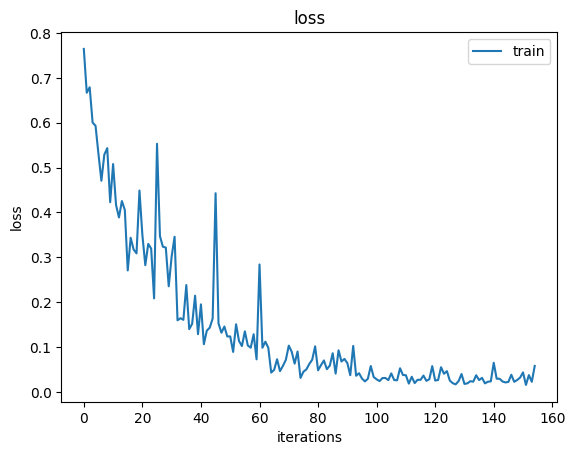

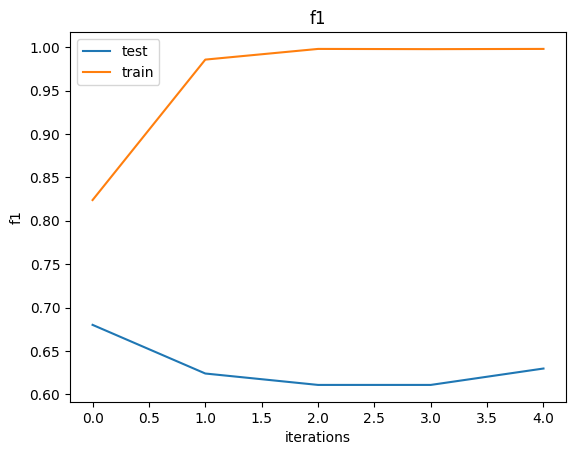

In [22]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=5)

training on device 'cuda'


Epoch 0:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.82214, f1: 0.75995
           Test accuracy: 0.74478, f1: 0.67243


Epoch 1:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.96515, f1: 0.95740
           Test accuracy: 0.71319, f1: 0.64475


Epoch 2:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.98873, f1: 0.98943
           Test accuracy: 0.74625, f1: 0.67772


Epoch 3:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99503, f1: 0.99658
           Test accuracy: 0.71822, f1: 0.73946


Epoch 4:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99819, f1: 0.99792
           Test accuracy: 0.72801, f1: 0.71622


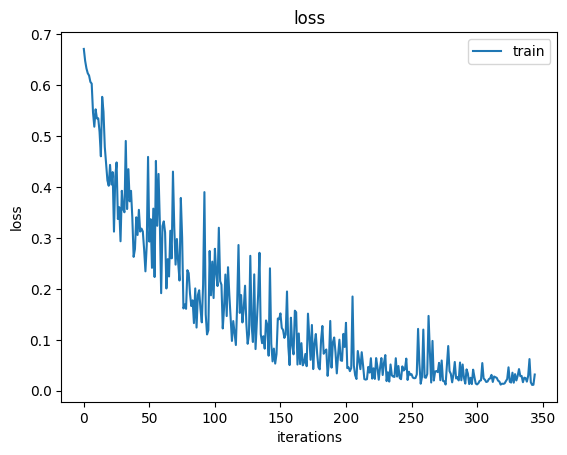

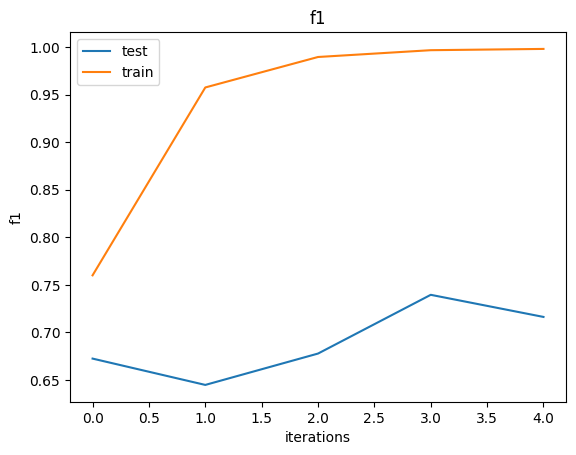

training on device 'cuda'


Epoch 0:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.78754, f1: 0.76970
           Test accuracy: 0.77143, f1: 0.68353


Epoch 1:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.92458, f1: 0.87376
           Test accuracy: 0.74782, f1: 0.63510


Epoch 2:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.97452, f1: 0.96985
           Test accuracy: 0.77357, f1: 0.70629


Epoch 3:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99658, f1: 0.99601
           Test accuracy: 0.77019, f1: 0.70326


Epoch 4:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99344, f1: 0.99459
           Test accuracy: 0.78775, f1: 0.74658


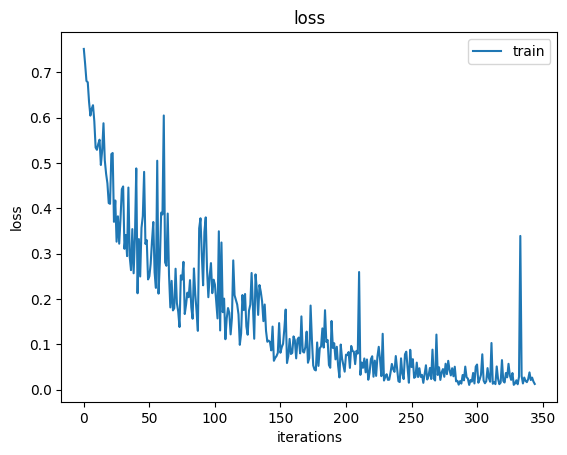

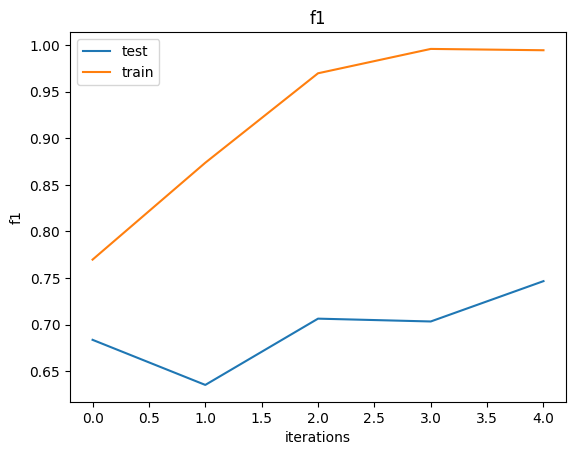

training on device 'cuda'


Epoch 0:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.77761, f1: 0.76795
           Test accuracy: 0.71456, f1: 0.73255


Epoch 1:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.91355, f1: 0.92293
           Test accuracy: 0.68933, f1: 0.71660


Epoch 2:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.98128, f1: 0.98568
           Test accuracy: 0.69072, f1: 0.72987


Epoch 3:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99638, f1: 0.99474
           Test accuracy: 0.78676, f1: 0.78838


Epoch 4:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99839, f1: 0.99733
           Test accuracy: 0.76691, f1: 0.75877


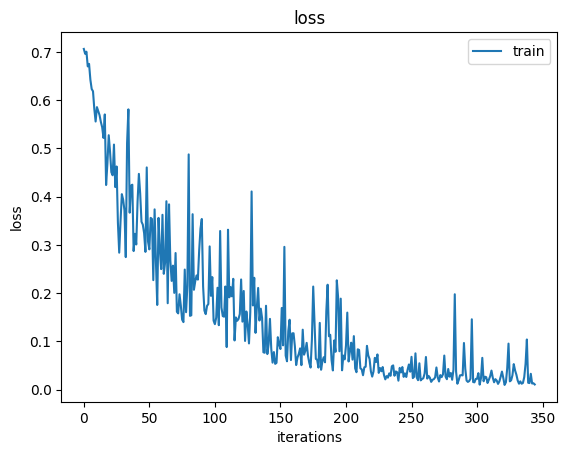

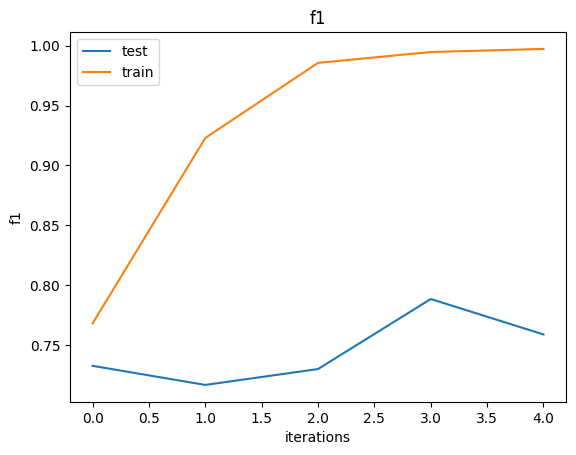

training on device 'cuda'


Epoch 0:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.80698, f1: 0.76030
           Test accuracy: 0.75366, f1: 0.70201


Epoch 1:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.91821, f1: 0.92614
           Test accuracy: 0.70465, f1: 0.67650


Epoch 2:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.97374, f1: 0.97568
           Test accuracy: 0.78450, f1: 0.76115


Epoch 3:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.98808, f1: 0.99132
           Test accuracy: 0.79241, f1: 0.77447


Epoch 4:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.00000, f1: 0.99903
           Test accuracy: 0.78430, f1: 0.73428


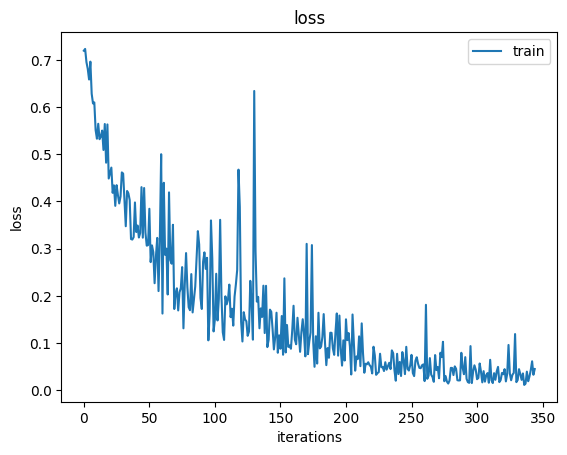

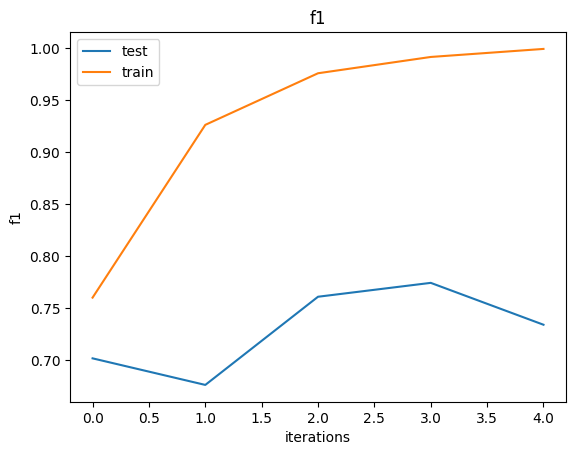

training on device 'cuda'


Epoch 0:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.83896, f1: 0.81933
           Test accuracy: 0.74824, f1: 0.66621


Epoch 1:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.93870, f1: 0.94450
           Test accuracy: 0.68036, f1: 0.63092


Epoch 2:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.98605, f1: 0.99243
           Test accuracy: 0.72707, f1: 0.70602


Epoch 3:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.99436, f1: 0.99698
           Test accuracy: 0.73137, f1: 0.65692


Epoch 4:   0%|          | 0/69 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 0.99612, f1: 0.99792
           Test accuracy: 0.73921, f1: 0.68534


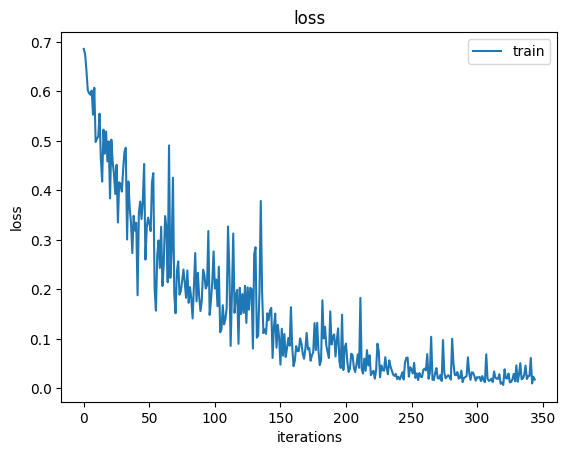

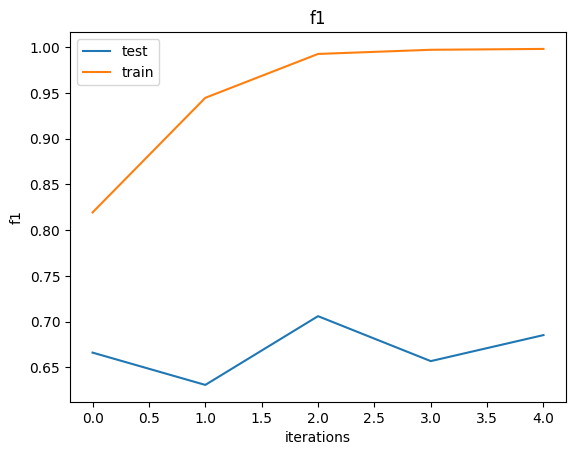

In [31]:
from sklearn.model_selection import KFold

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):

    # Sample elements randomly from a given list of ids, no replacement
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=32, collate_fn=default_collate, num_workers=0, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(
        dataset, batch_size=32, collate_fn=default_collate, num_workers=0, sampler=val_subsampler)

    # Init the neural network
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 1),  # output one value
    )

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  #pos_weight=torch.tensor([3.2]).to(device))  # binary Cross Entropy Loss with Logits

    num_epochs = 5
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # Run the training loop for defined number of epochs
    train(model, train_loader, test_loader, optimizer, scheduler, criterion, device, n_epochs=5)